# Neal's Funnel Target Practice

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/Documents/PhD/MicroCanonicalHMC.jl/examples`


In [2]:
# The statistical inference frame-work we will use
using Turing
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

# Extra deps
using LogDensityProblemsAD, LogDensityProblems

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end


true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{@NamedTuple{x::Vector{Float64}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DynamicPPL.DefaultContext()))

In [5]:
function _get_dists(vi)
    mds = values(vi.metadata)
    return [md.dists[1] for md in mds]
end

function _name_variables(vi, dist_lengths)
    vsyms = keys(vi)
    names = []
    for (vsym, dist_length) in zip(vsyms, dist_lengths)
        if dist_length == 1
            name = [string(vsym)]
            append!(names, name)
        else
            name = [string(vsym, i) for i = 1:dist_length]
            append!(names, name)
        end
    end
    return Vector{String}(names)
end

_name_variables (generic function with 1 method)

In [6]:
function TuringTarget(model; kwargs...)
    ctxt = model.context
    vi = DynamicPPL.VarInfo(model, ctxt)
    vi_t = Turing.link!!(vi, model)
    θ_start = vi[DynamicPPL.SampleFromPrior()]
    mds = values(vi.metadata)
    dists =  [md.dists[1] for md in mds]
    dist_lengths = [length(dist) for dist in dists]
    θ_names = _name_variables(vi, dist_lengths)
    d = length(θ_names)
    ℓ = LogDensityProblemsAD.ADgradient(DynamicPPL.LogDensityFunction(vi_t, model, ctxt))
    ℓπ(x) = LogDensityProblems.logdensity(ℓ, x)
    ∂lπ∂θ(x) = LogDensityProblems.logdensity_and_gradient(ℓ, x)
    
    function _reshape_params(x::AbstractVector)
        xx = []
        idx = 0
        for dist_length in dist_lengths
            append!(xx, [x[idx+1:idx+dist_length]])
            idx += dist_length
        end
        return xx
    end

    function transform(x)
        x = _reshape_params(x)
        xt = [Bijectors.link(dist, par) for (dist, par) in zip(dists, x)]
        return vcat(xt...)
    end

    function inv_transform(xt)
        xt = _reshape_params(xt)
        x = [Bijectors.invlink(dist, par) for (dist, par) in zip(dists, xt)]
        return vcat(x...)
    end

    return CustomTarget(ℓπ, ∂lπ∂θ, θ_start;
        transform=transform, 
        inv_transform=inv_transform, 
        θ_names=θ_names)
end

TuringTarget (generic function with 1 method)

In [7]:
target = TuringTarget(funnel_model)

String


MicroCanonicalHMC.Target{Float64}(21, MicroCanonicalHMC.Hamiltonian(var"#ℓπ#12"{LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{θ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:θ, typeof(identity)}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64, Float64, Float64}}, Vector{AbstractPPL.VarName{:θ, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, z::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:z, typeof(identity)}, Int64}, Vector{IsoNormal}, Vector{AbstractPPL.VarName{:z, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{@NamedTuple{x::Vector{Float64}}, DynamicPPL.DefaultContext}}, DynamicPPL.ConditionContext{@NamedTuple{x::Vector{Float64}}, DynamicPPL.DefaultContext}}, ForwardDiff.Chunk{11}, ForwardDiff.Tag{DynamicPPL.DynamicPPLTag, Float64}, ForwardDiff.GradientC

## MCHMC

In [9]:
mchmc = MCHMC(20_000, 0.01; adaptive=true)
espl = externalsampler(mchmc)

Turing.Inference.ExternalSampler{MicroCanonicalHMC.MCHMCSampler, AutoForwardDiff{nothing, Nothing}, true}(MicroCanonicalHMC.MCHMCSampler(20000, 0.01, true, true, true, true, MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, [0.0], 0.0, 0.0, 0.0), MicroCanonicalHMC.Leapfrog), AutoForwardDiff{nothing, Nothing}(nothing))

In [10]:
samples = sample(funnel_model, espl, 100_000);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
Tuning: 100%|███████████████████████████████████████████| Time: 0:02:15
  ϵ:     1.0016733142648795
  L:     7879.3905299734615
  dE/d:  0.014180776901292734
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


In [11]:
theta_mchmc = [samples.value.data[i, 1, :][1] for i in axes(samples.value.data)[1]]
x10_mchmc = [samples.value.data[i, 10+1, :][1] for i in axes(samples.value.data)[1]];

In [18]:
ssamples = Sample(mchmc, target, 100_000)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


24×50000 Matrix{Float64}:
  -2.91038     -2.90691      -2.89931     …   -0.288195    -0.0825508
   0.331038     0.637943      0.426912        -0.703009    -0.206151
   0.386373     0.443429      0.275205         0.344951     0.923632
  -0.0307636   -0.32264      -0.415502         0.0170465   -0.255363
  -0.49207     -0.49785       0.0171043        0.822458     1.02032
   0.187605     0.144874      0.0865758   …    0.189644     0.322097
  -0.472861    -0.625683     -0.329203        -2.27943     -1.54419
  -0.196116    -0.070315      0.0471575       -1.87074     -1.35496
  -0.434444    -0.333156     -0.123177         0.544736     0.583921
  -0.110981     0.199667      0.106557        -0.76501     -0.473178
  -0.37985     -0.196976     -0.00681777  …   -0.557298    -0.365607
   0.332094    -0.0129446    -0.182672         0.836934     1.11121
  -0.111793    -0.0834752    -0.0298604       -0.419171    -0.362107
  -0.632135    -0.702591     -0.517503         1.5155       1.26745
  -0.0773847

In [33]:
println(mean(ssamples[1, :]), " ", std(ssamples[1, :]))
println(mean(ssamples[11, :]), " ", std(ssamples[11, :]))

-0.1162738449508564 0.9702243481135476
-0.8193297713482686 0.7852897699709601


In [35]:
println(mean(theta_mchmc), " ", std(theta_mchmc))
println(mean(x10_mchmc), " ", std(x10_mchmc))

-0.39408159747045773 1.2875343544418831
-0.7345098968270953 0.7627960355617235


## NUTS

In [12]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:45


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 50.18 seconds
Compute duration  = 50.18 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           θ   -0.0015    0.7147    0.0090    7982.8130    5538.7109    1.0000 ⋯
        z[1]    0.6078    0.7299    0.0031   55674.6739   34269.0630    1.0001 ⋯
        z[2]    0.6221    0.7359    0.0032   54301.2027   33665.9053    1.0000 ⋯
        z[3]   -0.4

In [13]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [14]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:13


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 136.46 seconds
Compute duration  = 136.46 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           θ   -0.0020    0.7166    0.0053   19555.6860   22868.4280    1.0001 ⋯
        z[1]    0.5763    0.7005    0.0026   71079.2098   35177.6701    1.0000 ⋯
        z[2]    0.5831    0.7060    0.0026   71371.0605   35288.8766    1.0001 ⋯
        z[3]   -0

In [15]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


## Comp

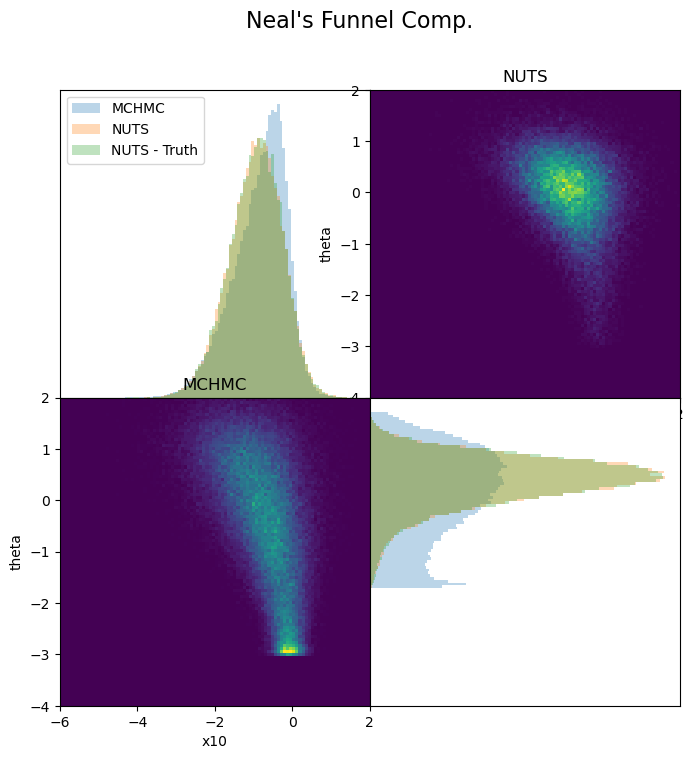

PyObject Text(0.5, 1.0, 'MCHMC')

In [16]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")